In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental import preprocessing

from risk_model import Model
from datetime import datetime

import plotly.graph_objects as go
from pandas_datareader import data as pdr
%matplotlib inline

from absl import logging
tf.get_logger().setLevel('ERROR')

float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
tf.random.set_seed(123)

np.random.seed(123)
yf.pdr_override()  # <== that's all it takes :-)


very_small_float = 1.0 #0.000000001

2022-09-04 15:49:06.190917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-04 15:49:06.190985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from bt_testcode import backtest, DynRebalance, get_name, plotAllocation, getStatistic, calc_portfolio_values
from bt_testcode import plotPortfolioReturns, get_portfolio_values

# Test Model

In [3]:
ticker = ['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY']
history_range = {'start': datetime(2008, 1, 1), 
                 'end': datetime(2020, 10, 1)}

stock = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')

[*********************100%***********************]  10 of 10 completed


In [4]:
stock_close = stock.iloc[:125]['Close'].reset_index(drop=True).fillna(very_small_float)
stock_close.head()

,AAPL,AEE,AIG,AMD,AMZN,BA,C,MO,MSFT,WY
0,7.074286,54.209999,1166.0,7.50,4.6320,87.459999,294.399994,75.580002,35.599998,73.739998
1,6.958571,53.349998,1126.0,7.14,4.8125,86.620003,289.200012,74.930000,35.220001,71.519997
2,6.961786,53.310001,1129.0,6.77,4.7605,86.980003,289.299988,75.389999,35.369999,72.199997
3,6.430357,52.919998,1106.0,6.25,4.4395,85.820000,282.399994,74.900002,34.380001,68.620003
4,6.344286,53.610001,1126.0,6.08,4.4410,82.870003,282.600006,77.230003,34.610001,68.129997


In [5]:
rnd = 8
tf.random.set_seed(rnd)
np.random.seed(rnd)

param={}
param ={'model_params':
    {'model_n':'LSTM',
    'epochs':1000}}

m = Model()
alloc = m.get_allocations(stock_close.values, **param['model_params'])
alloc

2022-09-04 15:49:24.539871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-04 15:49:24.539954: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-04 15:49:24.540017: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (divyanshu-PC): /proc/driver/nvidia/version does not exist


1/1 [==============================] - 1s 970ms/step


array([0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       0.0000, 0.0000], dtype=float32)

In [6]:
calc_portfolio_values(alloc, stock_close)

portfolio_returns: -0.1385
std: 0.0388
sharpe: -0.0288


In [7]:

n = [0, 200, 250, 300, 350, 400, 500, 700, 1000, 1300]
def getReturnFromAlloc(n):
    r_list = []
    param={}
    param ={'model_params':
        {'model_n':'LSTM',
        'epochs':1000}}
    print('ret, std, sharp')
    for i in n:
        stock_close = stock.iloc[i:i+125]['Close'].reset_index(drop=True).fillna(very_small_float)
        m = Model()
        alloc = m.get_allocations(stock_close.values, **param['model_params'])
        r_list.append((get_portfolio_values(alloc, stock_close)))
        #print(r_list[-1])
    return r_list

rl = getReturnFromAlloc(n)
sharp = []
for r, s, sp in rl:
    print("{:.4f}  {:.4f}  {:.4f}".format(r,s,sp))
    sharp.append(sp)

pd.DataFrame({'LSTM':sharp}).to_csv('lstm_alloc_result.csv')

ret, std, sharp
1/1 [==============================] - 1s 777ms/step
-0.1385  0.0388  -0.0288
0.5576  0.0461  0.0976
0.5209  0.0250  0.1683
0.6142  0.0186  0.2659
0.5268  0.0164  0.2587
0.2736  0.0119  0.1847
0.3175  0.0197  0.1301
0.4444  0.0177  0.2022
0.1616  0.0079  0.1641
0.3003  0.0131  0.1853


In [8]:
ticker = ['SPY', 'TLT', 'GLD', 'RWO']
history_range = {'start': datetime(2010, 1, 1), 
                 'end': datetime(2020, 10, 1)}

stock = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')

rl = getReturnFromAlloc(n)
sharp = []
for r, s, sp in rl:
    print("{:.4f}  {:.4f}  {:.4f}".format(r,s,sp))
    sharp.append(sp)

pd.DataFrame({'LSTM':sharp}).to_csv('lstm_alloc_result_2.csv')

[*********************100%***********************]  4 of 4 completed
ret, std, sharp
1/1 [==============================] - 1s 728ms/step
0.1333  0.0110  0.0974
0.1100  0.0075  0.1176
0.0612  0.0086  0.0574
0.2570  0.0120  0.1722
0.1978  0.0123  0.1300
0.1878  0.0159  0.0955
0.0909  0.0098  0.0750
0.1395  0.0065  0.1738
0.0724  0.0063  0.0934
-0.0262  0.0104  -0.0204


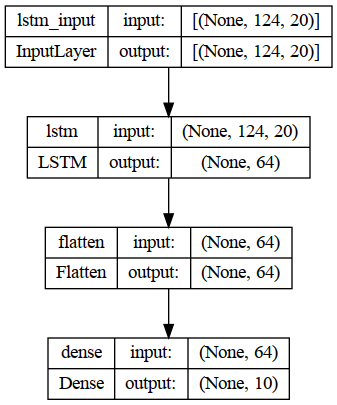

In [9]:
tf.keras.utils.plot_model(m.getModel(), show_shapes=True)

## Back test
Strategy:
We calculate the best assets allocations based on our model and we assue that this allocation will be the same for the next m days. We don't do any prediction of future returns.

# Back test 2008-2010

In [10]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    #'assets':['SPY', 'TLT', 'GLD', 'BA', 'SLV', 'WYNN','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2008, 1, 1),
    'endd'  : datetime(2010, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':100}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value: 11000.00
1/1 [==============================] - 0s 42ms/step
Final Portfolio Value: 14564.33


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM,9.794084,59.432101,0.125445,14564.330647


<AxesSubplot:xlabel='data'>

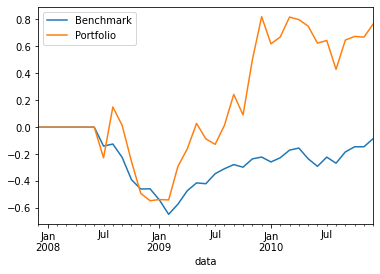

In [11]:
params['model'] = Model()
params['resetModel'] = False

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [12]:
plotAllocation(ah.dropna())

In [13]:
d_res = {}
d_stat = {}

Starting Portfolio Value: 11000.00
1/1 [==============================] - 0s 58ms/step
Final Portfolio Value: 4354.36


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,-26.545033,75.597294,-0.138512,4354.362046


<AxesSubplot:xlabel='data'>

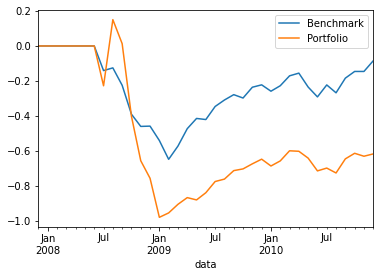

In [14]:
params['model'] = Model()
params['resetModel'] = True


d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [15]:
plotAllocation(ah.dropna())

In [16]:
getStatistic(d_stat).sort_values(by=['Sharp_Ratio'], ascending=False)

/home/divyanshu/Documents/GitHub/BTP/CodeFromVideo/bt_testcode.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,-26.545033,75.597294,-0.138512,4354.362046


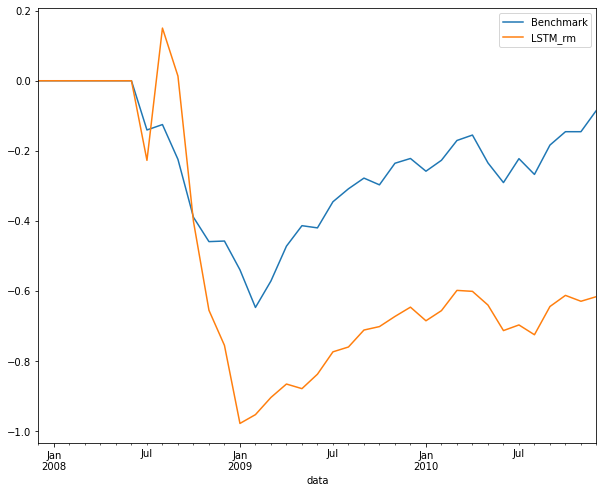

In [17]:
df = plotPortfolioReturns(d_res)

In [18]:
getStatistic(d_stat).to_csv('Lstm_stat_2008_2010.csv')
df.to_csv('Lstm_drawdown_2008_2010.csv')

/home/divyanshu/Documents/GitHub/BTP/CodeFromVideo/bt_testcode.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# TEST 2011-2017

In [19]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2011, 1, 1),
    'endd'  : datetime(2017, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':100}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value: 11000.00
1/1 [==============================] - 0s 30ms/step
Final Portfolio Value: 58357.93


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,26.954213,30.040134,0.324266,58357.934536


<AxesSubplot:xlabel='data'>

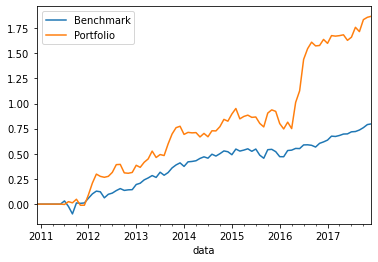

In [20]:
params['model'] = Model()
params['resetModel'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [21]:
plotAllocation(ah.dropna())

In [22]:
getStatistic(d_stat).sort_values(by=['Sharp_Ratio'], ascending=False)

/home/divyanshu/Documents/GitHub/BTP/CodeFromVideo/bt_testcode.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,26.954213,30.040134,0.324266,58357.934536


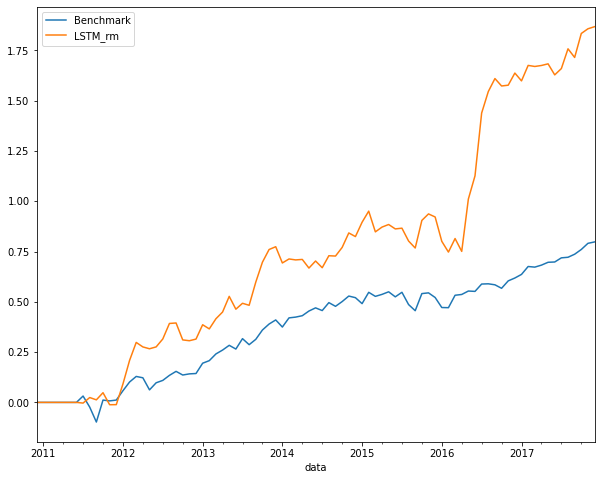

In [23]:
df = plotPortfolioReturns(d_res)

In [24]:
getStatistic(d_stat).to_csv('Lstm_stat_2011_2017.csv')
df.to_csv('Lstm_drawdown_2011_2017.csv')

/home/divyanshu/Documents/GitHub/BTP/CodeFromVideo/bt_testcode.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# Test 2018-2021

In [25]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2018, 1, 1),
    'endd'  : datetime(2021, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':100}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value: 11000.00
1/1 [==============================] - 0s 41ms/step
Final Portfolio Value: 19285.78


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,15.085776,31.21378,0.204557,19285.776522


<AxesSubplot:xlabel='data'>

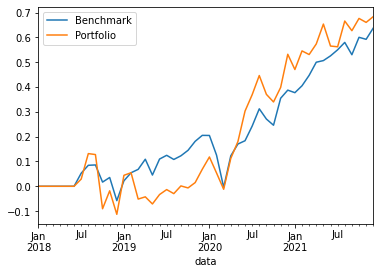

In [26]:
params['model'] = Model()
params['resetModel'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [27]:
plotAllocation(ah.dropna())

In [28]:
getStatistic(d_stat).sort_values(by=['Sharp_Ratio'], ascending=False)

/home/divyanshu/Documents/GitHub/BTP/CodeFromVideo/bt_testcode.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,15.085776,31.21378,0.204557,19285.776522


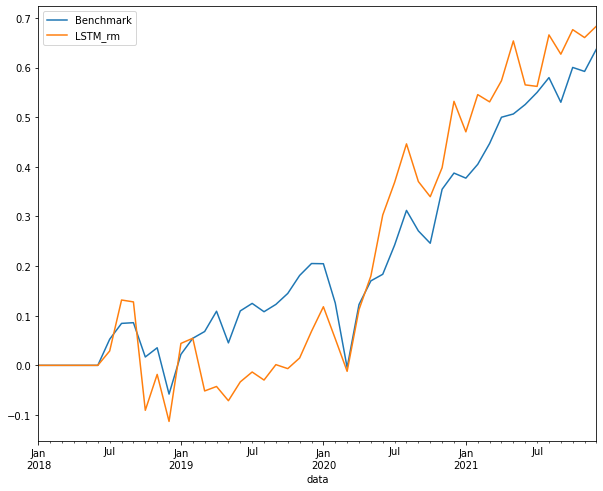

In [29]:
df = plotPortfolioReturns(d_res)

In [30]:
getStatistic(d_stat).to_csv('Lstm_stat_2018_2021.csv')
df.to_csv('Lstm_drawdown_2018_2021.csv')

/home/divyanshu/Documents/GitHub/BTP/CodeFromVideo/bt_testcode.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# TEST 2012-2016

In [31]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2012, 1, 1),
    'endd'  : datetime(2016, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':100}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value: 11000.00
1/1 [==============================] - 1s 505ms/step
Final Portfolio Value: 20750.84


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,13.557614,21.976021,0.255994,20750.843154


<AxesSubplot:xlabel='data'>

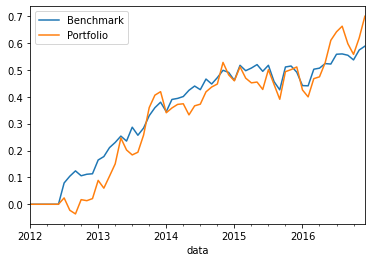

In [32]:
params['model'] = Model()
params['resetModel'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [33]:
plotAllocation(ah.dropna())

In [34]:
getStatistic(d_stat).sort_values(by=['Sharp_Ratio'], ascending=False)

/home/divyanshu/Documents/GitHub/BTP/CodeFromVideo/bt_testcode.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,13.557614,21.976021,0.255994,20750.843154


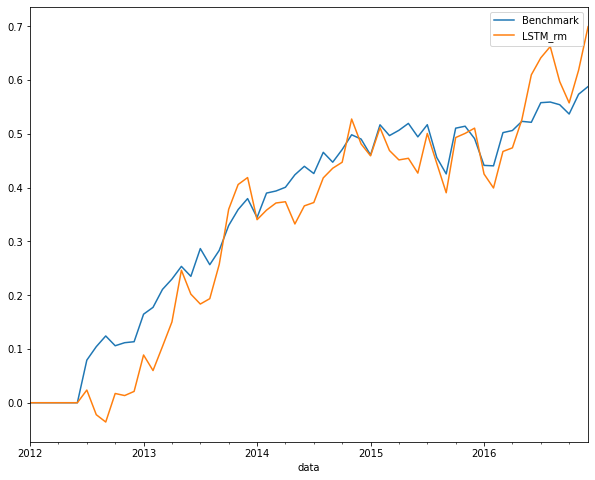

In [35]:
df = plotPortfolioReturns(d_res)

In [36]:
getStatistic(d_stat).to_csv('Lstm_stat_2012_2016.csv')
df.to_csv('Lstm_drawdown_2012_2016.csv')

/home/divyanshu/Documents/GitHub/BTP/CodeFromVideo/bt_testcode.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# 2016-2021 
SPY, TLT, GLD, IYR

In [37]:
config_cerebro = {
    'assets':['SPY', 'TLT', 'GLD', 'RWO'],
    'benchmark':'SPY',
    'startd': datetime(2016, 1, 1),
    'endd'  : datetime(2021, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':1000}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value: 11000.00
1/1 [==============================] - 0s 34ms/step
Final Portfolio Value: 12712.81


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,2.442871,30.430913,0.081744,12712.809212


<AxesSubplot:xlabel='data'>

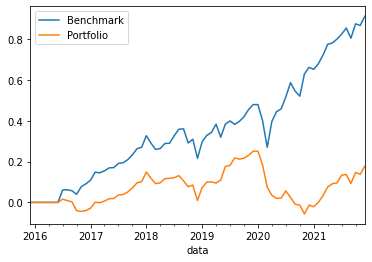

In [38]:
params['model'] = Model()
params['resetModel'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [39]:
plotAllocation(ah.dropna())

In [40]:
getStatistic(d_stat).sort_values(by=['Sharp_Ratio'], ascending=False)

/home/divyanshu/Documents/GitHub/BTP/CodeFromVideo/bt_testcode.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,2.442871,30.430913,0.081744,12712.809212


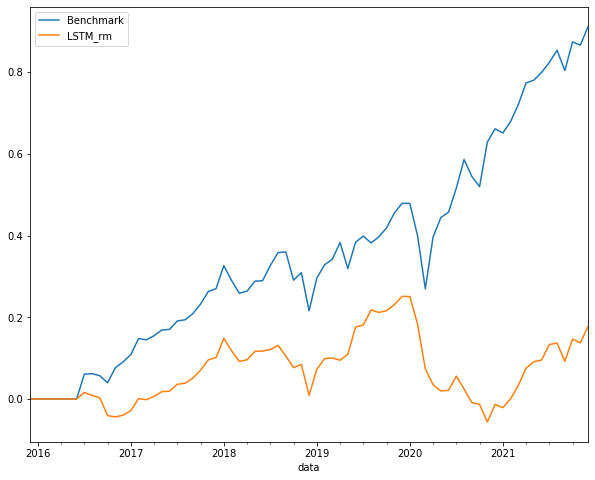

In [41]:
df = plotPortfolioReturns(d_res)

In [42]:
getStatistic(d_stat).to_csv('Lstm_stat_etf_2016_2021.csv')
df.to_csv('Lstm_drawdown_etf_2016_2021.csv')

/home/divyanshu/Documents/GitHub/BTP/CodeFromVideo/bt_testcode.py:95: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

